In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


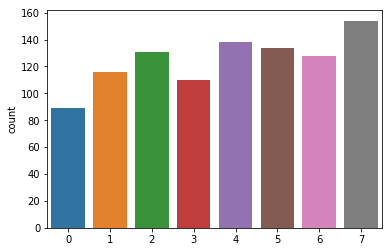

In [5]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [6]:
# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
#y_obs = np.loadtxt(folder+"answers_GLOBAL.txt",dtype='int16') 

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) 

N,T = y_obs.shape
Kl = np.max(y_obs)+1 #asumming classification scenario
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


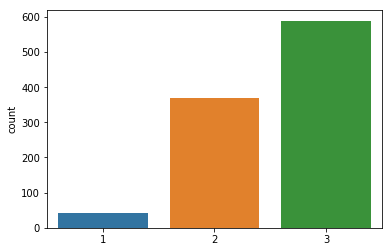

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


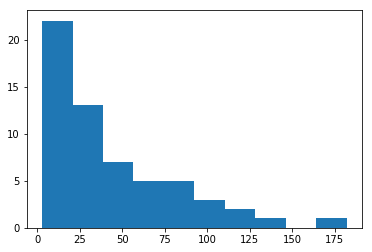

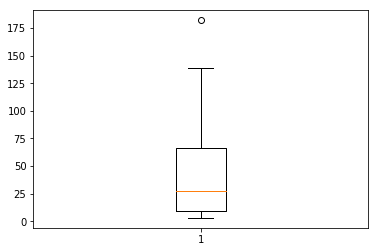

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Generate Matrix representation of both scenarios

In [8]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (1000, 59, 8)
Global representation shape (N,K)=  (1000, 8)


In [9]:
r_obs

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int32)

### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [10]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (59, 8, 8)


array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

Global matrix shape (K,K)=  (8, 8)


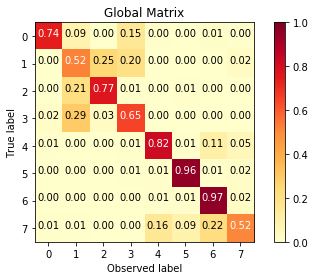

In [11]:
from codeE.utils import generate_Global_conf

#confe_matrix_G = generate_Global_conf(Z_train, y_obs_categorical)
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, np.arange(8), title= "Global Matrix")

#### Delta Convergence criteria

In [12]:
from codeE.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from codeE.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [13]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 13


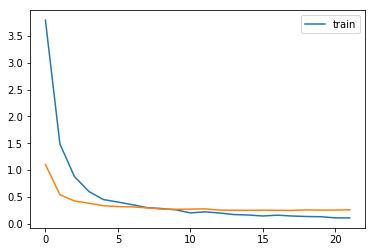

In [14]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [15]:
from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.992
Test accuracy of model = 0.92003367003367


In [16]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.9927582597557324
Test accuracy of model = 0.9207958635539998


## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [16]:
from codeE.baseline import LabelAggregation
label_A = LabelAggregation(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 2, 1, 4, 5, 2, 0, 4, 2, 5, 0, 1, 2, 3, 1, 3, 6, 4, 7, 4, 1, 1,
       2, 1, 3, 6, 0, 4, 6, 2, 4, 3, 6, 6, 5, 7, 4, 0, 5, 4, 5, 5, 2, 0,
       4, 2, 1, 5, 1, 6, 1, 7, 1, 0, 1, 6, 6, 7, 4, 4, 2, 3, 0, 5, 1, 1,
       4, 5, 2, 6, 4, 1, 7, 6, 6, 1, 5, 6, 6, 4, 1, 3, 6, 5, 4, 5, 6, 4,
       0, 4, 7, 0, 3, 3, 5, 5, 7, 4, 1, 3, 5, 4, 4, 1, 7, 7, 6, 2, 4, 2,
       2, 1, 7, 4, 0, 7, 7, 4, 0, 1, 6, 4, 7, 7, 2, 2, 2, 4, 1, 3, 1, 6,
       0, 6, 6, 1, 6, 0, 4, 6, 0, 3, 0, 5, 7, 0, 4, 3, 2, 3, 4, 0, 5, 6,
       4, 3, 0, 6, 1, 7, 3, 1, 7, 2, 1, 7, 0, 3, 5, 5, 1, 0, 5, 2, 6, 2,
       5, 4, 2, 5, 5, 2, 5, 4, 3, 3, 6, 4, 0, 1, 0, 4, 7, 2, 5, 0, 7, 4,
       1, 0, 0, 5, 0, 3, 6, 4, 1, 7, 1, 1, 1, 4, 6, 5, 5, 4, 1, 6, 1, 2,
       1, 5, 5, 4, 4, 7, 2, 0, 2, 0, 1, 5, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1,
       6, 4, 2, 6, 2, 7, 5, 4, 3, 4, 2, 7, 6, 4, 2, 1, 5, 7, 3, 3, 5, 6,
       1, 6, 6, 1, 7, 3, 5, 2, 6, 5, 1, 1, 6, 1, 1, 5, 1, 4, 4, 1, 5, 3,
       6, 2, 6, 4, 3, 6, 1, 4, 1, 3, 6, 0, 2, 6, 0,

In [17]:
from codeE.baseline import LabelAggregation
label_A = LabelAggregation(scenario="individual")

mv_soft = label_A.infer(  y_obs_categorical, 'softMV')
mv_hard = label_A.predict(y_obs_categorical, 'hardMV')
mv_soft

array([[0.        , 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333334, 0.6666667 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333334, 0.33333334, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.33333334, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [19]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.769


### generate confusion matrix to understand MV

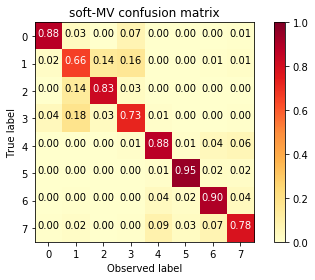

In [18]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotators

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(prob_Yz, np.arange(8), title= "soft-MV confusion matrix")

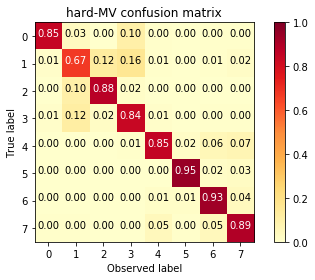

In [19]:
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, np.arange(8), title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

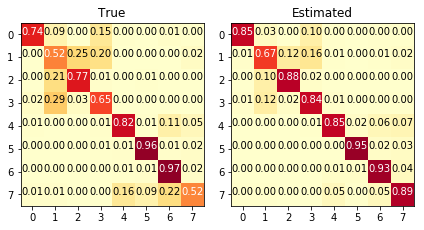

In [20]:
from codeE.utils import compare_conf_mats
compare_conf_mats(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [21]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.057157068901963225
Global D (based on normalized Frobenius) = 0.07360906898975372


##### Weighted

In [24]:
from codeE.baseline import LabelAggregation
label_A = LabelAggregation(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.        , 0.33088234, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33742332, 0.6625767 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.30601093, 0.19125684, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.08484849, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [25]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.762


### DS model

In [ ]:
from codeE.baseline import DS
N,K,T = y_obs_categorical.shape
DS_model = DS( lo q necesite...
    
    Xstd_train.shape[1:], K=K, T=T, init_Z="softmv",
                    epochs=1,batch_size=BATCH_SIZE, optimizer=OPT,DTYPE_OP=DTYPE_OP)


# if you want you can initialize step E forcing some method
DS_model.init_E(y_obs_categorical, method="hardmv")
DS_model.get_qestimation()

In [ ]:
DS_model.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

In [ ]:
ds_labels = DS_model.infer() #could infer/predict on the trainint set..
ds_labels

In [38]:
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


### Second Phase
train a predictive model over the inference/aggregation label

In [16]:
from codeE.evaluation import accuracy_model

In [37]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
#Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 8
Train accuracy of model = 0.822
Test accuracy of model = 0.8148148148148148


In [38]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard, num_classes=Kl)
mv_hard_onehot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [40]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_mvhard.predict_classes(Xstd_train)
#Z_test_pred = model_mvhard.predict_classes(Xstd_test)
print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 15
Train accuracy of model = 0.792
Test accuracy of model = 0.7878787878787878


In [41]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_ds.predict_classes(Xstd_train)
#Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 12


## Raykar Model (joint predict model)

In [14]:
from codeE.baseline import RaykarMC
N,T,K = y_obs_categorical.shape
raykarMC = RaykarMC(Xstd_train.shape[1:], K=K, T=T, init_Z="softmv",
                    epochs=1,batch_size=BATCH_SIZE, optimizer=OPT, DTYPE_OP=DTYPE_OP)

raykarMC.define_model('keras_import', clone_UB.get_model())
raykarMC.base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [57]:
# if you want you can initialize step E forcing some method
raykarMC.init_E(y_obs_categorical, method="hardmv")
raykarMC.get_qestimation()

Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
#logL_hists,i_r = raykarMC.multiples_run(20, Xstd_train,y_obs_categorical,
#                                        max_iter=EPOCHS_BASE, tolerance=TOL)

raykarMC.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.48 sec)	logL: -3399.309	
Iter 2/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2839.970	Tol1: 0.16455	Tol2: 0.13528	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2632.170	Tol1: 0.07317	Tol2: 0.05789	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2529.097	Tol1: 0.03916	Tol2: 0.02851	
Iter 5/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2460.818	Tol1: 0.02700	Tol2: 0.02333	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.45 sec)	logL: -2900.318	
Iter 2/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2574.208	Tol1: 0.11244	Tol2: 0.08395	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2435.714	Tol1: 0.05380	Tol2: 0.03476	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2360

M step: done,  E step: done //  (in 0.02 sec)	logL: -2509.070	Tol1: 0.01979	Tol2: 0.01784	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.41 sec)	logL: -3281.172	
Iter 2/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -2821.826	Tol1: 0.13999	Tol2: 0.12261	
Iter 3/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -2631.033	Tol1: 0.06761	Tol2: 0.05066	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2529.394	Tol1: 0.03863	Tol2: 0.03239	
Iter 5/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2453.793	Tol1: 0.02989	Tol2: 0.02428	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.42 sec)	logL: -3125.358	
Iter 2/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2620.858	Tol1: 0.16142	Tol2: 0.10497	
Iter 3/50 
M step: done,  E step: done //  (in 0.02 sec)	logL

([[-3399.309, -2839.9697, -2632.17, -2529.0967, -2460.8184],
  [-2900.3176, -2574.2075, -2435.7139, -2360.8975, -2318.5608],
  [-2960.29, -2604.5046, -2485.2788, -2410.2368, -2367.9],
  [-3125.5679, -2692.0952, -2501.89, -2420.317, -2380.4917],
  [-3265.7246, -2721.6257, -2524.1082, -2435.8442, -2377.2017],
  [-3273.65, -2754.1008, -2545.3823, -2432.233, -2367.7708],
  [-2989.6272, -2589.391, -2450.1296, -2390.1152],
  [-3159.559, -2702.3203, -2537.3716, -2448.2156, -2391.7166],
  [-3414.1665, -2774.559, -2532.1484, -2440.8179, -2386.1768],
  [-3333.844, -2863.6265, -2669.8076, -2560.926, -2494.6042],
  [-3207.876, -2723.0967, -2557.724, -2478.6372, -2421.1277],
  [-2943.8218, -2610.752, -2499.5972, -2441.9482],
  [-2970.4543, -2572.2795, -2442.9573, -2379.773],
  [-2980.6807, -2630.9526, -2492.3523, -2426.526],
  [-3334.1567, -2831.567, -2644.2166, -2559.726, -2509.0696],
  [-3281.1716, -2821.8262, -2631.0332, -2529.3943, -2453.7935],
  [-3125.3584, -2620.858, -2456.4504, -2389.3828],

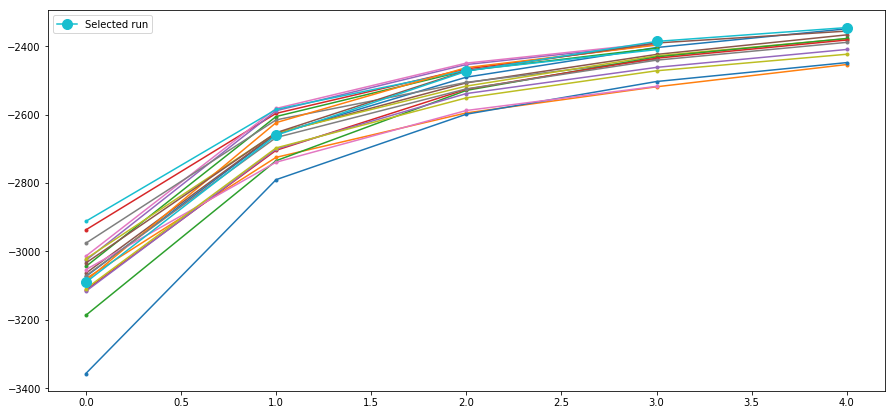

In [19]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [16]:
raykar_fx = raykarMC.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.839
Test accuracy of model = 0.8055555555555556


In [17]:
prob_Yzt = raykarMC.get_confusionM() # estimate of conf_matrix_I

from codeE.evaluation import Individual_D, D_JS, D_NormF
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.29517727753928663
Individual D_NormF =  0.17632851800170996


In [18]:
prob_Yz = prob_Yzt.mean(axis=0)
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.25938135332188605
Global D (based on normalized Frobenius) = 0.1683790534734726


## Our Proposed - CMM

In [15]:
M_seted = 3

In [16]:
from codeE.MixtureofGroups import CMM
N,K = r_obs.shape
gMixture_Global = CMM(Xstd_train.shape[1:],K=K,M=M_seted, init_Z='softmv',
                      epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 

#gMixture_Global.define_model("mlp",start_units=128,deep=1,BatchN=False,drop=0.5)
gMixture_Global.define_model("keras_import", clone_UB.get_model())    
gMixture_Global.get_basemodel().summary()

Model: "predictive_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [30]:
gMixture_Global.init_E(Xstd_train,r_obs, method='softmv')

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005732 mins
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)


In [33]:
#logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
#                                               max_iter=EPOCHS_BASE,tolerance=TOL)

gMixture_Global.fit(Xstd_train,r_obs, runs =20,
                        max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006301 mins
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.77 sec)	logL: -1967.816	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1733.139	Tol1: 0.11926	Tol2: 0.24525	Tol3: 0.26373	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1655.695	Tol1: 0.04468	Tol2: 0.09767	Tol3: 0.25450	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1581.100	Tol1: 0.04505	Tol2: 0.06204	Tol3: 0.24269	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1524.705	Tol1: 0.03567	Tol2: 0.04121	Tol3: 0.21040	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1494.199	Tol1: 0.02001	Tol2: 0.02847	Tol3: 0.18577	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005701 mins
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.6

M step: done,  E step: done //  (in 0.10 sec)	logL: -1641.867	Tol1: 0.06071	Tol2: 0.09820	Tol3: 0.24656	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1581.644	Tol1: 0.03668	Tol2: 0.05853	Tol3: 0.23372	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1536.961	Tol1: 0.02825	Tol2: 0.03799	Tol3: 0.21116	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1507.857	Tol1: 0.01894	Tol2: 0.03464	Tol3: 0.17028	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1456.589	Tol1: 0.03400	Tol2: 0.02559	Tol3: 0.14159	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1428.431	Tol1: 0.01933	Tol2: 0.02385	Tol3: 0.11325	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005870 mins
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2027.701	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1768.588	Tol1: 0.12779	

M step: done,  E step: done //  (in 0.09 sec)	logL: -1514.397	Tol1: 0.03089	Tol2: 0.03813	Tol3: 0.21231	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1475.872	Tol1: 0.02544	Tol2: 0.03279	Tol3: 0.18701	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1455.353	Tol1: 0.01390	Tol2: 0.02123	Tol3: 0.13858	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006220 mins
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2001.591	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1766.451	Tol1: 0.11748	Tol2: 0.23931	Tol3: 0.26013	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1686.059	Tol1: 0.04551	Tol2: 0.09772	Tol3: 0.26113	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1589.499	Tol1: 0.05727	Tol2: 0.06295	Tol3: 0.22883	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1525.045	Tol1: 0.04055	

([array([-1967.81621304, -1733.13866274, -1655.69537448, -1581.09997639,
         -1524.70506243, -1494.1992088 ]),
  array([-2007.8029274 , -1790.66386915, -1666.75399255, -1608.07063577,
         -1554.62118596, -1491.53467566, -1466.06564319]),
  array([-2071.02089156, -1772.38025812, -1641.23592427, -1558.71312501,
         -1505.78982601, -1471.39608636]),
  array([-1983.0193229 , -1762.86840757, -1668.46499295, -1586.61631829,
         -1536.27216534, -1484.13229385, -1447.51368925]),
  array([-2042.10620581, -1804.7222455 , -1669.88492029, -1584.2016908 ,
         -1521.85485904, -1482.56857769, -1466.61918407]),
  array([-1989.72415478, -1788.19678873, -1684.11281674, -1612.57099428,
         -1550.36198635, -1513.28291785]),
  array([-2107.88306369, -1825.57207165, -1689.41755641, -1608.11789789,
         -1550.50489243, -1483.16330821, -1452.285767  ]),
  array([-2002.66148766, -1737.69300941, -1639.86465443, -1564.69037793,
         -1513.77593278, -1469.84708467, -1455.3816

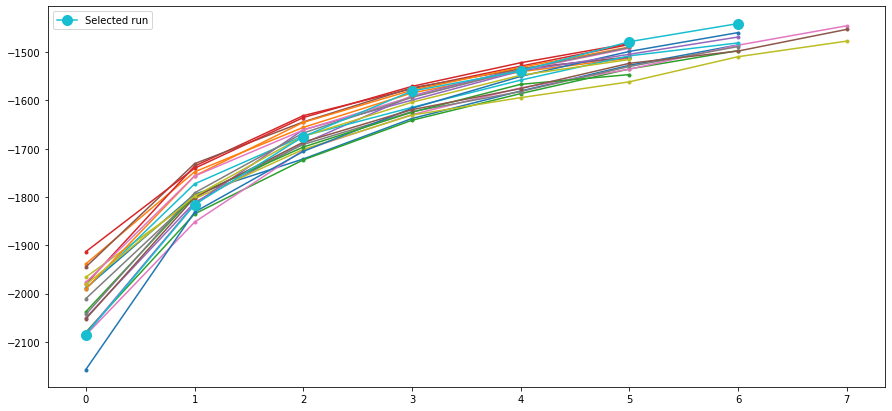

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [34]:
cmm_fx = gMixture_Global.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

Train accuracy of model = 0.841
Test accuracy of model = 0.8148148148148148


## Our Proposed - C-MoA

#### Auxiliar representation with variable number of annotations per annotator and identity

In [41]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

#### Annotators representation

In [18]:
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (59, 8)


In [19]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K,input_length=1, 
                         trainable=False,weights=[A_rep]))
#                         trainable=True))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 8)              472       
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 75        
Total params: 763
Trainable params: 291
Non-trainable params: 472
_________________________________________________________________


In [25]:
from codeE.MixtureofGroups import CMOA
gMixture_Ind = CMOA(Xstd_train.shape[1:],K=K,M=M_seted,init_Z="softmv", pre_init_z=3,
                                epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Ind.define_model("keras_import", clone_UB.get_model())
gMixture_Ind.get_basemodel().summary()

gMixture_Ind.define_model_group("keras_import",model=group_model)
gMixture_Ind.get_groupmodel().summary()

Model: "predictive_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________
Model: "group_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 8)              472       
_________________________

In [43]:
gMixture_Ind.init_E(Xstd_train,Y_ann_train, T_idx, method='softmv')

Initializing new EM...
Doing clustering...Done!
Pre-train networks over *z* on 3 epochs... Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)


In [26]:
#logL_hists,i_r = gMixture_Ind.multiples_run(20,Xstd_train,Y_ann_train, T_idx, 
#                                   max_iter=EPOCHS_BASE,tolerance=TOL) 

gMixture_Ind.fit(Xstd_train,Y_ann_train, T_idx, runs = 20, 
                                   max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...Done!
Pre-train networks over *z* on 3 epochs... Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -1760.276	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1565.589	Tol1: 0.11060	Tol2: 0.26133	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1483.264	Tol1: 0.05258	Tol2: 0.08645	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1423.879	Tol1: 0.04004	Tol2: 0.06683	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1383.101	Tol1: 0.02864	Tol2: 0.04238	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1349.021	Tol1: 0.02464	Tol2: 0.03041	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1319.295	Tol1: 0.02204	Tol2: 0.03350	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1297.957	Tol1: 0.01617	Tol2: 0.03181	
Iter 9/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -1284.180	Tol1: 0

M step: done,  E step: done //  (in 0.20 sec)	logL: -1422.482	Tol1: 0.03384	Tol2: 0.06380	
Iter 5/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -1404.220	Tol1: 0.01284	Tol2: 0.03840	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1357.126	Tol1: 0.03354	Tol2: 0.03986	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1326.864	Tol1: 0.02230	Tol2: 0.04233	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -1296.392	Tol1: 0.02297	Tol2: 0.03604	
Iter 9/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -1270.431	Tol1: 0.02003	Tol2: 0.03543	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1257.960	Tol1: 0.00982	Tol2: 0.02153	
Finished training!
Initializing new EM...
Doing clustering...Done!
Pre-train networks over *z* on 3 epochs... Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.39 sec)	logL: -1734.304	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -1549.4

M step: done,  E step: done //  (in 1.34 sec)	logL: -1740.961	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1538.272	Tol1: 0.11642	Tol2: 0.27420	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1464.373	Tol1: 0.04804	Tol2: 0.07460	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1424.663	Tol1: 0.02712	Tol2: 0.05999	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1395.462	Tol1: 0.02050	Tol2: 0.04282	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -1374.620	Tol1: 0.01494	Tol2: 0.04999	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -1319.026	Tol1: 0.04044	Tol2: 0.03236	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -1292.551	Tol1: 0.02007	Tol2: 0.03750	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -1280.421	Tol1: 0.00938	Tol2: 0.02967	
Finished training!
Initializing new EM...
Doing clustering...Done!
Pre-train networks over *z* on 3 epochs... Done!
Betas:  (3, 8

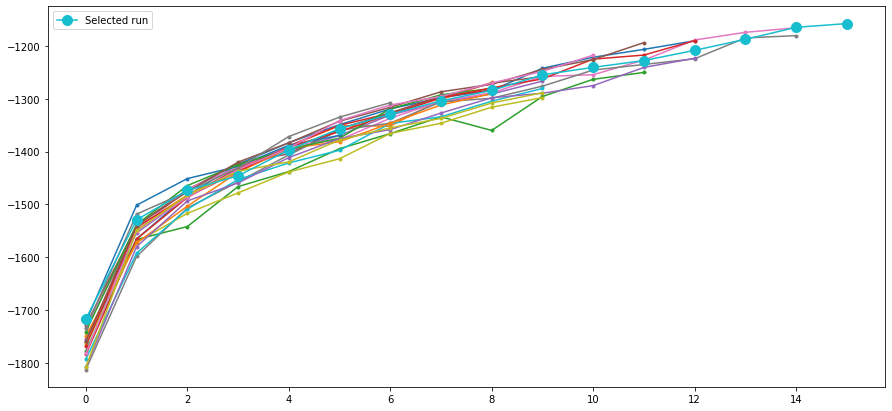

In [27]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [23]:
cmoaK_fx = gMixture_Ind.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

Train accuracy of model = 0.8
Test accuracy of model = 0.8392255892255892


### Compare trained models

In [29]:
#Import it:
from codeE.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [29]:
aux_tr = []
aux_te = []
eps = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    eps.append(len(hist.epoch))
    
print("Epochs: ",np.mean(eps))
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

Epochs:  11.55


,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.97315,0.97315,0.974759,0.012285,0.012285,0.012054


In [17]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.924285,0.924285,0.925649,0.005386,0.005386,0.005658


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(T_idx_unique)  ########

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [66]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

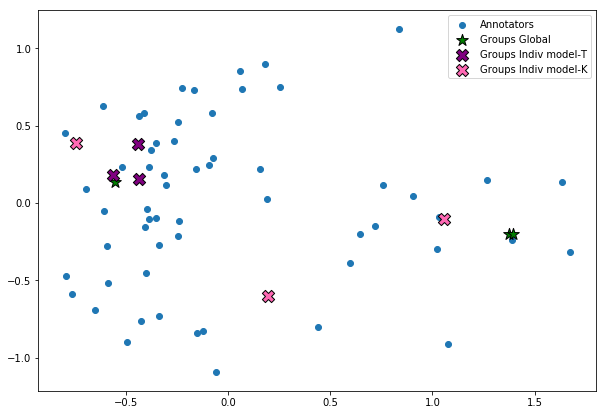

In [67]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo